##### CSCI 303
# Introduction to Data Science
<p/>
### 8 - Scikit Learn Basics

![Scikit learn logo](scikit-learn-logo.png) 

## This Lecture
---
- Basic usage of the Scikit learn package

## Setup
---
We'll typically start a notebook from now on with a set of standard imports, and any relevant Jupyter notebook "magic" directives:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

%matplotlib inline

## Example Problem Setup
---
We'll continue to use our synthetic problem to illustrate linear regression in Scikit learn:

$$ \begin{align} & f(x) =  3 + 0.5 n - n^2 + 0.15 n^3 \\
                 & y = f(x) + \epsilon 
   \end{align} $$

In [2]:
# "ground truth" function
def f(x):
    return 3 + 0.5 * x - x**2 + 0.15 * x**3


Some more functions:

In [3]:
# ensure repeatability of this notebook 
# (comment out for new results each run)
np.random.seed(12345)

# convenience function for generating samples
def sample(n, fn, limits, noise=1):
    width = limits[1] - limits[0]
    x = np.random.random(n) * width + limits[0]
    y = fn(x) + np.random.randn(n) * noise
    return x, y

# there's a scikit learn tool for generating
# polynomial features - this will be more useful
# when working with multivariate inputs, so we'll
# stick with this simpler solution for now
def phi(x, k):
    return np.array([x ** p for p in range(k)]).T

## Regression Workflow
---
- Obtain training samples (data and target)
- [optional] Do some initial visualization, statistics
- [optional] Preprocess data (generate features, dimensionality reduction)
- Initialize a model object
- Split data into training and test sets (or use cross validation, more on this another time)
- Train the model
- Use the trained model to make predictions
- Evaluate approximation quality (e.g., examine MSE)
- Visualize results
- Repeat steps as needed to refine model

## Obtain Training Samples
---
Usually this involves getting data from an external source: the internet, your own research, etc.

For today, we'll simply sample from our synthetic problem.

In [4]:
n = 40

# we'll start using scikit learn's names for things
data, target = sample(n, f, [-5,5], 3)

## Initial Visualization
---
This varies a lot.  One common visualization is scatter plots showing correlations between pairs of inputs and/or the training data:

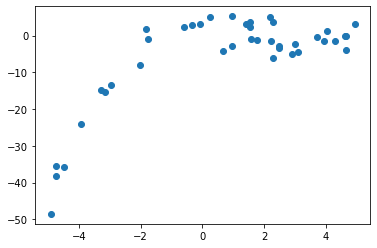

In [5]:
plt.scatter(data, target)
plt.show()

## Preprocess Data
---
Our initial visualization suggests non-linearity.  Let's use some polynomial features.

In [6]:
Phi = phi(data, 5) # 5 functions
Phi.shape

(40, 5)

## Initialize a Model Object
---
Now we get to some actual Scikit learn code.  

There are a bunch of regression models; we're going to use the one.

The basic process of obtaining a model, training, and then using it for prediction is uniform-ish across learning methods.  Yay!

In [7]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=False) # default

The `fit_intercept` parameter above defaults to True, but we already generated an intercept term in our design matrix.

## Split Data into Training/Test Sets
---
There's a Scikit learn for this:

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Phi, target, test_size = 0.5)

The `test_size` parameter is used to control what percentage of the data to hold out for testing.

We can check to see that our data matrices/vectors are the size expected:

In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(20, 5) (20, 5) (20,) (20,)


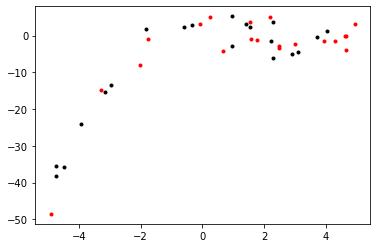

In [10]:
plt.plot(X_train[:,1], y_train, 'k.', X_test[:,1], y_test, 'r.')

## Train the Model
---
This is done using the `fit` method of the model object:

In [11]:
lr.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

## Predict (and Visualize)
---
Let's see what we got:

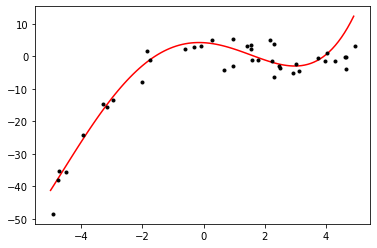

In [12]:
x = np.arange(-5, 5, 0.1)
yhat = lr.predict(phi(x, 5))
plt.plot(x, yhat, 'r-', data, target, 'k.')
plt.show()

In our case, we also know ground truth, so let's add that in:

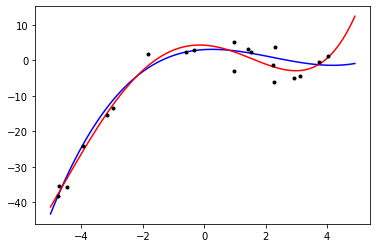

In [13]:
plt.plot(x, f(x), 'b-', x, yhat, 'r-', X_train[:,1], y_train, 'k.') # all rows, select 1st column
plt.show()

## Evaluate
---
Let's compute MSE and RMSE on our test set:

In [14]:
MSE = ((y_test - lr.predict(X_test)) ** 2).mean()
RMSE = np.sqrt(MSE)
print("MSE: ", MSE)
print("RMSE:", RMSE)

MSE:  30.201240859904964
RMSE: 5.495565563243238


## Refine Model
---
A lot we could do here!  For now, let's repeat our work on evaluating RMSE for different orders.

I have to redo some work from above to get all the powers up to 12...

In [15]:
Phi = phi(data, 12)
X_train, X_test, y_train, y_test = train_test_split(Phi, target, test_size = 0.5)

Now I can just pare down my feature matrices using NumPy's array slicing capabilities.

This works somewhat like list slicing, but with multi-dimensional support:

In [16]:
print(Phi.shape)

print(Phi[:,:3].shape) # all rows, start at beginning, stop at 3

(40, 12)
(40, 3)


Compute RMSEs across a range of orders and find the minimum:

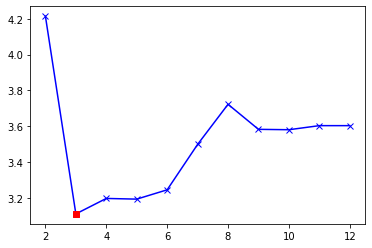

3.1110201095243624 at order 3


In [18]:
RMSEs = []
orders = range(2,13)
for p in orders:
    lr.fit(X_train[:,:(p+1)], y_train)
    MSE = ((y_test - lr.predict(X_test[:,:(p+1)])) ** 2).mean()
    RMSEs.append(np.sqrt(MSE))
RMSEs = np.array(RMSEs)
plt.plot(orders, RMSEs, 'b-x')
plt.plot(orders[RMSEs.argmin()], RMSEs.min(), 'rs') # marks the lowest RMSE value a red square
plt.show()
print(RMSEs.min(), "at order", orders[RMSEs.argmin()])

In [19]:
lr.fit(X_train[:,:5], y_train)

LinearRegression(fit_intercept=False)

In [20]:
lr.score(X_test[:,:5], y_test)

0.8768295733190168

In [21]:
X_test.shape

(20, 12)

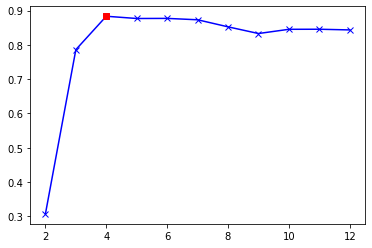

0.8833925877665701 at order 4


In [23]:
COEFFs = []
for p in orders:
    lr.fit(X_train[:,:p], y_train)
    COEFFs.append(lr.score(X_test[:,:p], y_test))
COEFFs = np.array(COEFFs)
plt.plot(orders, COEFFs, 'b-x')
plt.plot(orders[COEFFs.argmax()], COEFFs.max(), 'rs') # plots the max value with a red square
plt.show()
print(COEFFs.max(), "at order", orders[COEFFs.argmax()])